In [7]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from cell_load.utils.data_utils import filter_on_target_knockdown,set_var_index_to_col

if 'MPLBACKEND' in os.environ:
    del os.environ['MPLBACKEND']

In [8]:
import requests
from tqdm.auto import tqdm

# url = "https://storage.googleapis.com/vcc_data_prod/datasets/state/competition_support_set.zip"
# output_path = "competition_support_set.zip"

# # 流式下载并显示进度
# response = requests.get(url, stream=True)
# total = int(response.headers.get("content-length", 0))
# with open(output_path, "wb") as f, tqdm(
#     total=total, unit='B', unit_scale=True, desc="Downloading"
# ) as bar:
#     for chunk in response.iter_content(chunk_size=8192):
#         if chunk:  # 过滤空块
#             f.write(chunk)
#             bar.update(len(chunk))

In [9]:
# from zipfile import ZipFile

# out_dir = "competition_support_set/competition_support_set"

# import os
# os.environ['MPLBACKEND'] = 'Agg'  # 避免PyTorch Lightning绘图时的交互冲突
# os.environ['WANDB_MODE'] = 'offline'  # 可选：强制Wandb离线模式，避免登录弹窗


In [10]:
# train_random = ad.read_h5ad("train_random.h5ad")
# print("数据中所有 target_gene 类别：")
# print(train_random.obs['target_gene'].unique())

In [11]:
train_adata = ad.read_h5ad("competition_support_set/competition_train.h5")
print(train_adata)

AnnData object with n_obs × n_vars = 221273 × 18080
    obs: 'target_gene', 'guide_id', 'batch', 'batch_var', 'cell_type'
    uns: 'log1p'


n_obs（221273）：数据集中包含 221,273 个细胞（每个细胞是一个样本）；
n_vars（18080）：每个细胞测量了 18,080 个基因的表达量（即基因表达矩阵 adata.X 的维度为 (221273, 18080)

obs 是细胞层面的元信息表格（每行对应一个细胞）
![Alt text](image.png)
uns: 'log1p'：
uns 是 “非结构化注释信息”，log1p 表示该数据已做 log(1 + 表达量) 标准化（单细胞转录组数据的常用预处理方式，用于降低表达量极值的影响，使数据更符合模型训练的正态分布假设）。

这一点很重要：模型训练时无需重复做 log1p 标准化，避免数据过度处理；后续推理时，也需确保输入数据（如 competition_val_template.h5ad）的标准化方式与训练数据一致。

In [12]:
print(train_adata.obs.head())

                                   target_gene                   guide_id  \
AAACAAGCAACCTTGTACTTTAGG-Flex_1_01       CHMP3  CHMP3_P1P2_A|CHMP3_P1P2_B   
AAACAAGCATTGCCGCACTTTAGG-Flex_1_01        AKT2    AKT2_P1P2_A|AKT2_P1P2_B   
AAACCAATCAATGTTCACTTTAGG-Flex_1_01       SHPRH  SHPRH_P1P2_A|SHPRH_P1P2_B   
AAACCAATCCCTCGCTACTTTAGG-Flex_1_01      TMSB4X    TMSB4X_P1_A|TMSB4X_P1_B   
AAACCAATCTAAATCCACTTTAGG-Flex_1_01       KLF10      KLF10_P2_A|KLF10_P2_B   

                                        batch  batch_var cell_type  
AAACAAGCAACCTTGTACTTTAGG-Flex_1_01  Flex_1_01  Flex_1_01    ARC_H1  
AAACAAGCATTGCCGCACTTTAGG-Flex_1_01  Flex_1_01  Flex_1_01    ARC_H1  
AAACCAATCAATGTTCACTTTAGG-Flex_1_01  Flex_1_01  Flex_1_01    ARC_H1  
AAACCAATCCCTCGCTACTTTAGG-Flex_1_01  Flex_1_01  Flex_1_01    ARC_H1  
AAACCAATCTAAATCCACTTTAGG-Flex_1_01  Flex_1_01  Flex_1_01    ARC_H1  


在 Flex_1_01 这个批次中，细胞 AAACAAGCAACCTTGTACTTTAGG 是一个 ARC_H1 细胞，它被设计用来扰动 CHMP3 基因，并使用了 CHMP3_P1P2_A|CHMP3_P1P2_B 这种特定的引导 RNA 组合。

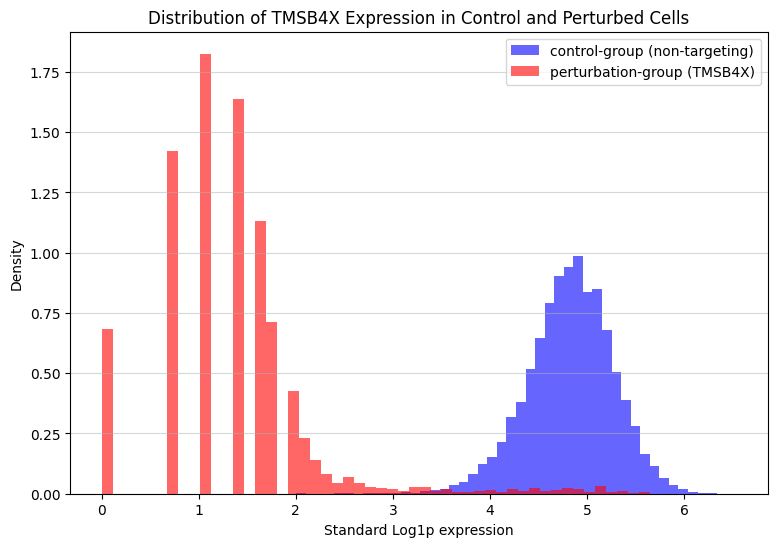

In [13]:
# 查看表达谱
specific_gene = 'TMSB4X'
control_pert = 'non-targeting'
try:
    s_gene = train_adata.var_names.get_loc(specific_gene)
except KeyError:
    print(f"Gene {specific_gene} 未找到")
    exit()

# 提取索引和表达数据
ctrl_cells_idx = train_adata.obs['target_gene'] == control_pert
pert_cells_idx = train_adata.obs['target_gene'] == specific_gene
ctrl_expression = train_adata.X[ctrl_cells_idx.values, s_gene].toarray().flatten()
pert_expression = train_adata.X[pert_cells_idx.values, s_gene].toarray().flatten()


plt.figure(figsize=(9, 6))

# 绘制对照组分布
plt.hist(
    ctrl_expression, 
    bins=50, 
    alpha=0.6, 
    density=True,  # 使用密度，方便比较不同细胞数量的组
    label=f'control-group ({control_pert})',
    color='blue'
)

# 绘制扰动组分布
plt.hist(
    pert_expression, 
    bins=50, 
    alpha=0.6, 
    density=True, 
    label=f'perturbation-group ({specific_gene})',
    color='red'
)
plt.title(f'Distribution of {specific_gene} Expression in Control and Perturbed Cells')
plt.xlabel('Standard Log1p expression')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

横轴——表达谱：TMSB4X基因标准化处理后的活性水平（即表达量）的完整快照，直接定义细胞状态

纵轴——密度

直方图的含义实际上是单基因TMSB4X在有无扰动下的表达值密度分布

图表显示成功的敲除 (左移)：这证明了扰动是有效的，模型可以信任 TMSB4X 组细胞确实处于“TMSB4X 缺失”的细胞状态

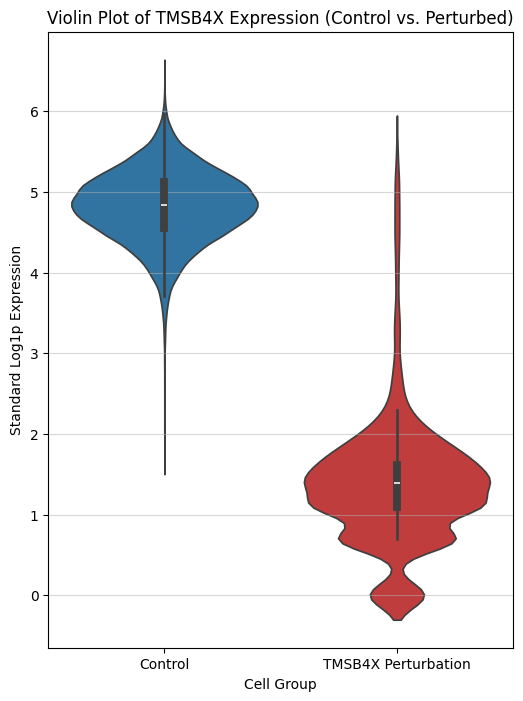

In [14]:
import pandas as pd
import seaborn as sns
plot_data = pd.DataFrame({
    'Expression': np.concatenate([ctrl_expression, pert_expression]),
    'Group': [control_pert] * len(ctrl_expression) + [specific_gene] * len(pert_expression)
})

# --- 步骤 4：绘制小提琴图 ---
plt.figure(figsize=(6, 8))

# 定义颜色，使对照组和处理组颜色区分明显
palette_map = {control_pert: '#1f77b4', specific_gene: '#d62728'} # 蓝色和红色

sns.violinplot(
    x='Group', 
    y='Expression', 
    data=plot_data, 
    palette=palette_map,
    inner='box' # 在小提琴内部显示一个箱线图，提供四分位数和中位数信息
)

plt.title(f'Violin Plot of {specific_gene} Expression (Control vs. Perturbed)')
plt.xlabel('Cell Group')
plt.ylabel('Standard Log1p Expression')
# 重新命名 x 轴标签，使其更清晰
plt.xticks(ticks=[0, 1], labels=['Control', specific_gene + ' Perturbation'])
plt.grid(axis='y', alpha=0.5)
plt.show()

In [15]:
# print(f"扰动基因类型和数量{train_adata.obs['target_gene'].value_counts().head(10)}")
print(f"扰动基因类型和对应的细胞数量{train_adata.obs['target_gene'].value_counts()}")

print(f"\n细胞类型分布:{train_adata.obs['cell_type'].value_counts().head(10)}")
print(f"\n批次分布:{train_adata.obs['batch'].value_counts()}")

扰动基因类型和对应的细胞数量target_gene
non-targeting    38176
TMSB4X            4760
PRCP              4331
TADA1             4035
HIRA              3407
                 ...  
BRD9                67
DNAJA3              65
OXA1L               63
RNF20               47
ATP6V0C             33
Name: count, Length: 151, dtype: int64

细胞类型分布:cell_type
ARC_H1    221273
Name: count, dtype: int64

批次分布:batch
Flex_3_10    5082
Flex_3_06    5068
Flex_3_15    5038
Flex_3_08    4988
Flex_3_11    4988
Flex_3_14    4980
Flex_3_03    4977
Flex_3_13    4955
Flex_3_04    4936
Flex_3_02    4895
Flex_3_07    4888
Flex_3_09    4834
Flex_3_16    4826
Flex_3_05    4825
Flex_2_13    4718
Flex_2_15    4716
Flex_2_06    4680
Flex_2_11    4673
Flex_3_01    4645
Flex_3_12    4627
Flex_2_14    4614
Flex_2_04    4575
Flex_1_13    4575
Flex_1_06    4565
Flex_1_15    4548
Flex_2_02    4527
Flex_2_10    4526
Flex_1_10    4512
Flex_2_01    4501
Flex_2_03    4499
Flex_2_08    4493
Flex_2_05    4472
Flex_2_07    4452
Flex_1_11    44

In [16]:
# val_template = ad.read_h5ad("competition_support_set/competition_val_template.h5ad")
# print(val_template)

In [17]:
# print(f"扰动基因类型和数量{val_template.obs['target_gene'].value_counts().head(10)}")
# print(f"\n细胞类型分布:{val_template.obs['cell_type'].value_counts()}")
# print(f"\n批次分布:{val_template.obs['batch_var'].value_counts()}")

In [18]:
hepg2_cells = ad.read_h5ad("competition_support_set/hepg2.h5")
print(hepg2_cells)
print(f"扰动基因类型和数量{hepg2_cells.obs['target_gene'].value_counts().head(10)}")
print(f"\n细胞类型分布:{hepg2_cells.obs['cell_type'].value_counts()}")
# print(f"\n批次分布:{hepg2_cells.obs['batch'].value_counts()}")

AnnData object with n_obs × n_vars = 9386 × 18080
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'batch_var', 'target_gene', 'cell_type'
扰动基因类型和数量target_gene
non-targeting    4976
TFAM             1213
EIF4B             217
JAZF1             153
TAF13             134
HIRA              129
MBTPS1            115
MAT2A             104
ARPC2              99
DNMT1              82
Name: count, dtype: int64

细胞类型分布:cell_type
hepg2    9386
Name: count, dtype: int64


In [19]:
jurkat_cells = ad.read_h5ad("competition_support_set/jurkat.h5")
print(jurkat_cells)
print(f"扰动基因类型和数量{jurkat_cells.obs['target_gene'].value_counts().head(10)}")
print(f"\n细胞类型分布:{jurkat_cells.obs['cell_type'].value_counts()}")
# print(f"\n批次分布:{hepg2_cells.obs['batch'].value_counts()}")

AnnData object with n_obs × n_vars = 21412 × 18080
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'batch_var', 'target_gene', 'cell_type'
扰动基因类型和数量target_gene
non-targeting    12013
TFAM              2555
EIF4B              461
JAZF1              265
HIRA               233
SMARCB1            204
TAF13              200
KDM1A              195
MBTPS1             192
LZTR1              192
Name: count, dtype: int64

细胞类型分布:cell_type
jurkat    21412
Name: count, dtype: int64


In [20]:
k562_gwps_cells = ad.read_h5ad("competition_support_set/k562_gwps.h5")
print(k562_gwps_cells)
print(f"扰动基因类型和数量{k562_gwps_cells.obs['target_gene'].value_counts().head(10)}")
print(f"\n细胞类型分布:{k562_gwps_cells.obs['cell_type'].value_counts()}")
# print(f"\n批次分布:{hepg2_cells.obs['batch'].value_counts()}")

AnnData object with n_obs × n_vars = 111605 × 18080
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'batch_var', 'target_gene', 'cell_type'
扰动基因类型和数量target_gene
non-targeting    75328
HIRA               608
DNMT1              509
KLF10              489
ARPC2              483
JAZF1              460
DHX36              435
TMSB10             433
SMARCB1            431
NISCH              412
Name: count, dtype: int64

细胞类型分布:cell_type
k562    111605
Name: count, dtype: int64


In [25]:
k562_cells = ad.read_h5ad("competition_support_set/k562.h5")
# print(k562_cells)
# print(f"扰动基因类型和数量{k562_cells.obs['target_gene'].value_counts().head(10)}")
# print(f"\n细胞类型分布:{k562_cells.obs['cell_type'].value_counts()}")
# print(type({k562_cells.obs['cell_type'].value_counts()}))
# print(f"\n批次分布:{hepg2_cells.obs['batch'].value_counts()}")

rpe1 = ad.read_h5ad("competition_support_set/rpe1.h5")
# print(f"\n{rpe1}")
# print(f"扰动基因类型和数量{rpe1.obs['target_gene'].value_counts().head(10)}")
# print(f"\n细胞类型分布:{rpe1.obs['cell_type'].value_counts()}")
# print(f"\n批次分布:{hepg2_cells.obs['batch'].value_counts()}")
print(rpe1.var.head())

Empty DataFrame
Columns: []
Index: [SAMD11, NOC2L, KLHL17, PLEKHN1, PERM1]


In [22]:
def cell_num(x):
    num = x.obs['cell_type'].value_counts().tolist()[0]
    return num
tol_cell_num = np.sum([cell_num(train_adata), cell_num(hepg2_cells), cell_num(jurkat_cells), cell_num(k562_gwps_cells), cell_num(k562_cells), cell_num(rpe1)])
print(f"\n总细胞数:{tol_cell_num}")

print(f"\n细胞类型分布:{train_adata.obs['cell_type'].value_counts()}")
print(f"\n细胞类型分布:{hepg2_cells.obs['cell_type'].value_counts()}")
print(f"\n细胞类型分布:{jurkat_cells.obs['cell_type'].value_counts()}")
print(f"\n细胞类型分布:{k562_gwps_cells.obs['cell_type'].value_counts()}")  
print(f"\n细胞类型分布:{k562_cells.obs['cell_type'].value_counts()}")

print(f"\n细胞类型分布:{rpe1.obs['cell_type'].value_counts()}")


总细胞数:404458

细胞类型分布:cell_type
ARC_H1    221273
Name: count, dtype: int64

细胞类型分布:cell_type
hepg2    9386
Name: count, dtype: int64

细胞类型分布:cell_type
jurkat    21412
Name: count, dtype: int64

细胞类型分布:cell_type
k562    111605
Name: count, dtype: int64

细胞类型分布:cell_type
k562    18465
Name: count, dtype: int64

细胞类型分布:cell_type
rpe1    22317
Name: count, dtype: int64


In [32]:
# 根据基因敲低效率过滤低质量扰动细胞和无效扰动批次

def ensure_gene_name_column(adata):
    if 'gene_name' not in adata.var.columns:
        adata.var['gene_name'] = adata.var.index
    return adata
print(train_adata.var.columns)
print("根据结果，要设置gene_name列")

train_adata = ensure_gene_name_column(train_adata)
hepg2_cells = ensure_gene_name_column(hepg2_cells)
jurkat_cells = ensure_gene_name_column(jurkat_cells)
k562_gwps_cells = ensure_gene_name_column(k562_gwps_cells)
k562_cells = ensure_gene_name_column(k562_cells)
rpe1 = ensure_gene_name_column(rpe1)

print(train_adata.var.columns)

train_adata_setvar = set_var_index_to_col(train_adata, col='gene_name')
hepg2_cells_setvar = set_var_index_to_col(hepg2_cells, col='gene_name')
jurkat_cells_setvar = set_var_index_to_col(jurkat_cells, col='gene_name')
k562_gwps_cells = set_var_index_to_col(k562_gwps_cells, col='gene_name')
k562_cells = set_var_index_to_col(k562_cells, col='gene_name')
rpe1 = set_var_index_to_col(rpe1, col='gene_name')

filtered_train_adata = filter_on_target_knockdown(adata=train_adata, 
                                            perturbation_column="target_gene",
                                            control_label="non-targeting",
                                            residual_expression=0.3,
                                            cell_residual_expression=0.5,
                                            min_cells=30,
                                            layer=None
                                            )
print(f"\n过滤后训练集细胞数:{filtered_train_adata.n_obs}")
print(f"\n过滤后细胞类型分布:{filtered_train_adata.obs['cell_type'].value_counts()}")
filtered_train_adata.write_h5ad("filtered_train_adata.h5ad")

filtered_hepg2 = filter_on_target_knockdown(adata=hepg2_cells, 
                                            perturbation_column="target_gene",
                                            control_label="non-targeting",
                                            residual_expression=0.3,
                                            cell_residual_expression=0.5,
                                            min_cells=50,
                                            layer=None
                                            )
print(f"\n过滤后HepG2细胞数:{filtered_hepg2.n_obs}")
print(f"\n过滤后细胞类型分布:{filtered_hepg2.obs['cell_type'].value_counts()}")
filtered_hepg2.write_h5ad("filtered_hepg2.h5ad")

filtered_jurkat = filter_on_target_knockdown(adata=jurkat_cells,
                                            perturbation_column="target_gene",
                                            control_label="non-targeting",
                                            residual_expression=0.3,
                                            cell_residual_expression=0.5,
                                            min_cells=50,
                                            layer=None
                                            )
print(f"\n过滤后Jurkat细胞数:{filtered_jurkat.n_obs}")
print(f"\n过滤后细胞类型分布:{filtered_jurkat.obs['cell_type'].value_counts()}")
filtered_jurkat.write_h5ad("filtered_jurkat.h5ad")

filtered_k562_gwps = filter_on_target_knockdown(adata=k562_gwps_cells,
                                            perturbation_column="target_gene",
                                            control_label="non-targeting",
                                            residual_expression=0.3,
                                            cell_residual_expression=0.5,
                                            min_cells=50,
                                            layer=None
                                            )
print(f"\n过滤后K562_GWPS细胞数:{filtered_k562_gwps.n_obs}")
print(f"\n过滤后细胞类型分布:{filtered_k562_gwps.obs['cell_type'].value_counts()}")
filtered_k562_gwps.write_h5ad("filtered_k562_gwps.h5ad")

filtered_k562 = filter_on_target_knockdown(adata=k562_cells,
                                            perturbation_column="gene",
                                            control_label="non-targeting",
                                            residual_expression=0.3,
                                            cell_residual_expression=0.5,
                                            min_cells=50,
                                            layer=None
                                            )
print(f"\n过滤后K562细胞数:{filtered_k562.n_obs}")
print(f"\n过滤后细胞类型分布:{filtered_k562.obs['cell_type'].value_counts()}")
filtered_k562.write_h5ad("filtered_k562.h5ad")

filtered_rpe1 = filter_on_target_knockdown(adata=rpe1,
                                            perturbation_column="gene",
                                            control_label="non-targeting",
                                            residual_expression=0.3,
                                            cell_residual_expression=0.5,
                                            min_cells=50,
                                            layer=None
                                            )
print(f"\n过滤后RPE1细胞数:{filtered_rpe1.n_obs}")
print(f"\n过滤后细胞类型分布:{filtered_rpe1.obs['cell_type'].value_counts()}")
filtered_rpe1.write_h5ad("filtered_rpe1.h5ad")

total_filtered_cells = np.sum([filtered_train_adata.n_obs, filtered_hepg2.n_obs, filtered_jurkat.n_obs, filtered_k562_gwps.n_obs, filtered_k562.n_obs, filtered_rpe1.n_obs])
print(f"\n总过滤后细胞数:{total_filtered_cells}")



Index(['gene_name'], dtype='object')
根据结果，要设置gene_name列
Index(['gene_name'], dtype='object')

过滤后训练集细胞数:195144

过滤后细胞类型分布:cell_type
ARC_H1    195144
Name: count, dtype: int64


Skipping perturbation 'LZTR1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'JAZF1': control mean expression is zero; cannot compute knock-down ratio.



过滤后HepG2细胞数:7221

过滤后细胞类型分布:cell_type
hepg2    7221
Name: count, dtype: int64


Skipping perturbation 'SDC1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'JAZF1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'ETV4': control mean expression is zero; cannot compute knock-down ratio.



过滤后Jurkat细胞数:19218

过滤后细胞类型分布:cell_type
jurkat    19218
Name: count, dtype: int64


Skipping perturbation 'DLG5': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'JAZF1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'FOXH1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'IKBKG': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'PRDM14': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'EPHB4': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'KLF10': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'NCK2': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'PBX1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'SDC1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'SALL4': co


过滤后K562_GWPS细胞数:98677

过滤后细胞类型分布:cell_type
k562    98677
Name: count, dtype: int64


Skipping perturbation 'JAZF1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'SDC1': control mean expression is zero; cannot compute knock-down ratio.



过滤后K562细胞数:15740

过滤后细胞类型分布:cell_type
k562    15740
Name: count, dtype: int64


Skipping perturbation 'LZTR1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'MED12': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'TADA1': control mean expression is zero; cannot compute knock-down ratio.
Skipping perturbation 'ETV4': control mean expression is zero; cannot compute knock-down ratio.



过滤后RPE1细胞数:20163

过滤后细胞类型分布:cell_type
rpe1    20163
Name: count, dtype: int64

总过滤后细胞数:356163


In [ ]:
train_adata_target_gene = train_adata[train_adata.obs['target_gene'] != 'non-targeting']
hepg2_cells_target_gene = hepg2_cells[hepg2_cells.obs['target_gene'] != 'non-targeting']
jurkat_cells_target_gene = jurkat_cells[jurkat_cells.obs['target_gene'] != 'non-targeting']
k562_gwps_cells_target_gene = k562_gwps_cells[k562_gwps_cells.obs['target_gene'] != 'non-targeting']
k562_cells_target_gene = k562_cells[k562_cells.obs['target_gene'] != 'non-targeting']
rpe1_target_gene = rpe1[rpe1.obs['target_gene'] != 'non-targeting']

train_adata_target_gene = set(train_adata_target_gene.obs['target_gene'].unique())
hepg2_cells_target_gene = set(hepg2_cells_target_gene.obs['target_gene'].unique())
jurkat_cells_target_gene = set(jurkat_cells_target_gene.obs['target_gene'].unique())
k562_gwps_cells_target_gene = set(k562_gwps_cells_target_gene.obs['target_gene'].unique())
k562_cells_target_gene = set(k562_cells_target_gene.obs['target_gene'].unique())
rpe1_target_gene = set(rpe1_target_gene.obs['target_gene'].unique())

all_sets = [train_adata_target_gene, hepg2_cells_target_gene, jurkat_cells_target_gene, k562_gwps_cells_target_gene, k562_cells_target_gene, rpe1_target_gene]

is_same = all(s==all_sets[0] for s in all_sets)
print(is_same)

In [ ]:
# 数据合并
share_dir = "competition_support_set/"
file_map = {
    "train_H1":os.path.join(share_dir, "competition_train.h5"),
    "hepg2":os.path.join(share_dir, "hepg2.h5"),
    "jurkat":os.path.join(share_dir, "jurkat.h5"),
    "k562_gwps":os.path.join(share_dir, "k562_gwps.h5"),
    "k562":os.path.join(share_dir, "k562.h5"),
    "rpe1":os.path.join(share_dir, "rpe1.h5"),
}

# adata_dict = {}
# for name, path in file_map.items():
#     print(f"Loading {name} from {path}...")
#     try:
#         adata_dict[name] = ad.read_h5ad(path)
#     except FileNotFoundError:
#         print(f"Error: File not found at {path}. Skipping.")
#         continue

# # 定义合并后的 AnnData 对象的列表
# list_of_adatas = list(adata_dict.values())

# # 执行合并操作 (按行/细胞)
# # join='outer'：确保所有基因（列）都被保留，这对于您的数据是必要的。
# # merge='unique'：确保 metadata 列不会因为重复值而冲突。
# # label：在 obs 中添加一个新列，标记每个细胞来自哪个原始文件（即字典的键）。
# # keys：用于填充 label 列的值。

# merged_adata = ad.concat(
#     list_of_adatas, 
#     axis=0,             # 按行（细胞）合并
#     join='outer',       # 确保所有基因列都匹配
#     merge='unique',     # 合并所有元数据列
#     # label='source_dataset', # 新增的列名
#     keys=list(adata_dict.keys()), # 新增列的值
#     fill_value=0        # 如果某个基因在某些数据集中缺失，填充0
# )

In [ ]:
# # 检查合并结果
# print("\n--- 合并结果检查 ---")
# print(merged_adata)
# print(f"合并后的总细胞数: {merged_adata.n_obs}")
# print(f"合并后的总基因数: {merged_adata.n_vars}")
# # print(f"新的源数据集标签分布:\n{merged_adata.obs['source_dataset'].value_counts()}")

# # 保存合并后的文件
# output_file = "all_cell_set.h5ad"
# merged_adata.write_h5ad(output_file)
# print(f"成功保存合并文件到: {output_file}")

In [ ]:
gene_sets = []
loaded_files_count = 0
for name, path in file_map.items():
    print(f"Processing {name}...")
    try:
        # 加载文件
        adata = ad.read_h5ad(path)
        
        # 筛选：只保留 target_gene 非 'non-targeting' 的细胞的 'target_gene' 列
        # 使用 .loc 进行高效的布尔索引和列选择
        perturbed_genes_series = adata.obs.loc[adata.obs['target_gene'] != 'non-targeting', 'target_gene']
        
        # 提取扰动基因并转换为集合
        gene_set = set(perturbed_genes_series.unique())
        gene_sets.append(gene_set)
        loaded_files_count += 1
        print(f"  {name} 包含 {len(gene_set)} 个扰动基因.")
        
    except FileNotFoundError:
        print(f"Error: File not found at {path}. Skipping.")
        continue
    except Exception as e:
        # 捕获其他可能的错误，如加载失败
        print(f"An unexpected error occurred while processing {name}: {e}. Skipping.")
        # 打印部分堆栈信息以供调试
        # import traceback; traceback.print_exc(file=sys.stdout)
        continue

# 2. 计算所有集合的交集 (共享基因)
print("\n--- 计算共享基因 ---")
if loaded_files_count == 0:
    print("无法计算交集，因为没有文件成功加载。")
elif len(gene_sets) == 1:
    print("只有一个文件加载成功，无法计算交集。")
else:
    # 使用 set.intersection() 来找到所有集合的交集,保证这些基因是所有细胞系都存在的
    shared_genes = set.intersection(*gene_sets)
    
    # 3. 打印结果
    print("\n--- 结果摘要 ---")
    print(f"在 {loaded_files_count} 个细胞系中共享的 target_gene 数量 (交集): {len(shared_genes)}")
    
    if len(shared_genes) > 0:
        # 仅打印前 10 个作为示例
        print("所有共享扰动基因 :")
        print(list(shared_genes))
    else:
        print("没有找到任何共同扰动的基因。")

# 计算每个细胞类型特有的扰动基因
print("\n--- 计算每个细胞系特有的扰动基因 ---")
unique_genes = {}
cell_line_sets = {
    "train_adata": train_adata_target_gene,
    "hepg2_cells": hepg2_cells_target_gene,
    "jurkat_cells": jurkat_cells_target_gene,
    "k562_gwps_cells": k562_gwps_cells_target_gene,
    "k562_cells": k562_cells_target_gene,
    "rpe1": rpe1_target_gene
}
for name, current_set in cell_line_sets.items():
    # 其他所有细胞系的集合（排除当前细胞系）
    other_sets = [s for n, s in cell_line_sets.items() if n != name]
    # 其他所有细胞系的基因并集（即“非当前细胞系的所有基因”）
    other_combined = set().union(*other_sets)
    # 当前细胞系独有的基因 = 当前集合 - 其他所有集合的并集
    unique = current_set - other_combined
    unique_genes[name] = unique

# 3. 输出结果（键：细胞系名称，值：独有的target_gene集合）
for cell_line, genes in unique_genes.items():
    print(f"{cell_line}: {genes}")

In [ ]:
# 找到shared_gene中出现次数最多的target_gene
shared_gene_count = {}
for gene in shared_genes:
    train_data_count = np.sum(train_adata.obs['target_gene'] == gene)
    hepg2_data_count = np.sum(hepg2_cells.obs['target_gene'] == gene)
    jurkat_data_count = np.sum(jurkat_cells.obs['target_gene'] == gene)
    k562_gwps_data_count = np.sum(k562_gwps_cells.obs['target_gene'] == gene)
    k562_data_count = np.sum(k562_cells.obs['target_gene'] == gene)
    rpe1_data_count = np.sum(rpe1.obs['target_gene'] == gene)
    total_count = (train_data_count + hepg2_data_count + jurkat_data_count + 
                   k562_gwps_data_count + k562_data_count + rpe1_data_count)
    shared_gene_count[gene] = total_count
max_gene = max(shared_gene_count, key=shared_gene_count.get)
print(max_gene, shared_gene_count[max_gene])

# 选取MBTPS1基因，看看其在每个细胞系中的数量是否足以支撑其作为测试集
# 考虑数量更多的TFAM
specific_gene = 'TFAM'
train_data_count = np.sum(train_adata.obs['target_gene'] == specific_gene)
hepg2_data_count = np.sum(hepg2_cells.obs['target_gene'] == specific_gene)
jurkat_data_count = np.sum(jurkat_cells.obs['target_gene'] == specific_gene)
k562_gwps_data_count = np.sum(k562_gwps_cells.obs['target_gene'] == specific_gene)
k562_data_count = np.sum(k562_cells.obs['target_gene'] == specific_gene)
rpe1_data_count = np.sum(rpe1.obs['target_gene'] == specific_gene)
print(f"train_data_count: {train_data_count}")
print(f"hepg2_data_count: {hepg2_data_count}")
print(f"jurkat_data_count: {jurkat_data_count}")
print(f"k562_gwps_data_count: {k562_gwps_data_count}")
print(f"k562_data_count: {k562_data_count}")
print(f"rpe1_data_count: {rpe1_data_count}")

total = (train_data_count + hepg2_data_count + jurkat_data_count +k562_gwps_data_count + k562_data_count + rpe1_data_count)
print(f"total:{total}")




In [ ]:
from collections import defaultdict
gene_to_cell_type = defaultdict(list)

print("--- 正在加载文件并构建基因-细胞类型映射 ---")

# 1. 循环加载文件、过滤，并构建映射
for cell_type_name, path in file_map.items():
    print(f"Processing {cell_type_name}...")
    try:
        adata = ad.read_h5ad(path)
        
        # 筛选：只保留 target_gene 非 'non-targeting' 的细胞的 'target_gene' 列
        perturbed_genes_series = adata.obs.loc[adata.obs['target_gene'] != 'non-targeting', 'target_gene']
        gene_set = set(perturbed_genes_series.unique())
        
        # 将该细胞类型中的所有基因添加到 gene_to_cell_type 字典中
        for gene in gene_set:
            gene_to_cell_type[gene].append(cell_type_name)
        
    except Exception as e:
        # 文件读取或处理失败时跳过
        print(f"Error processing {cell_type_name}. Skipping. Error: {e}")
        continue

# 2. 筛选：只保留至少出现在两个细胞类型中的基因
shared_genes_list = []
for gene, cell_types in gene_to_cell_type.items():
    if len(cell_types) >= 2:
        # 将细胞类型列表转换为逗号分隔的字符串
        cell_types_str = ", ".join(cell_types)
        shared_genes_list.append({
            'target_gene': gene,
            'Cell Types Containing the Gene': cell_types_str
        })

# 3. 创建 DataFrame 并排序
if shared_genes_list:
    df_shared_genes = pd.DataFrame(shared_genes_list)
    
    # 添加一个临时列用于排序
    df_shared_genes['Cell Type Count'] = df_shared_genes['Cell Types Containing the Gene'].apply(lambda x: len(x.split(', ')))
    # 按照共享细胞类型的数量降序排序
    df_shared_genes = df_shared_genes.sort_values(by='Cell Type Count', ascending=False).drop(columns=['Cell Type Count'])
    
    print("\n✅ 代码执行逻辑完成。请在您的环境中运行上述代码以查看最终结果。")
    print("\n以下是最终 DataFrame 的结构示例:")
    
    # 打印最终 DataFrame 结构
    print(df_shared_genes)

In [ ]:
all_cell_types = set()
loaded_files_count = 0

print("--- 正在读取并提取所有文件的 cell_type ---")

# 1. 循环加载文件并提取 cell_type
for name, path in file_map.items():
    try:
        adata = ad.read_h5ad(path)
        
        # 提取唯一的 cell_type 并将其添加到总集合中
        unique_types = adata.obs['cell_type'].unique()
        all_cell_types.update(unique_types)
        
        loaded_files_count += 1
        print(f"✅ {name} 包含的细胞类型: {list(unique_types)}")
        
    except FileNotFoundError:
        print(f"❌ Error: File not found at {path}. Skipping.")
        continue
    except KeyError:
        print(f"❌ Error: 'cell_type' column not found in {name}. Skipping.")
        continue
    except Exception as e:
        print(f"❌ An unexpected error occurred while processing {name}: {e}. Skipping.")
        continue

# 2. 打印最终的合并结果

print("\n--- 最终所有文件中独特的 cell_type 集合 ---")
if all_cell_types:
    # 转换为列表并排序，使其更易读
    final_list = sorted(list(all_cell_types))
    print(f"总共发现 {len(final_list)} 种独特的细胞类型:")
    print(final_list)
else:
    print("未能成功读取任何细胞类型。请检查文件路径和文件内容。")

In [ ]:
# # 为随机实验拆分数据集
# from sklearn.model_selection import train_test_split

# # --- 文件名定义 ---
# # 请将 input_file 更改为您实际合并后的文件名（如 merged_perturbation_atlas.h5ad）
# input_file = "all_cell_set.h5ad" 
# train_output_file = "train_random.h5ad"
# val_output_file = "val_random.h5ad"
# test_output_file = "test_random.h5ad"

# # 参数定义
# train_ratio = 0.8  # 80% 训练集
# val_ratio = 0.1    # 10% 验证集
# test_ratio = 0.1   # 10% 测试集
# random_seed = 42   # 确保结果可重现

# def extract_and_save(names_list, output_filename, source_adata):
#     """根据细胞名称列表提取 AnnData 子集并保存"""
#     mask = source_adata.obs_names.isin(names_list)
#     subset_view = source_adata[mask, :] 
#     subset_adata = subset_view.to_memory() 
#     subset_adata.write_h5ad(output_filename, compression='gzip')
#     return subset_adata.n_obs

# try:
#     # 1. 使用 backed='r' 加载合并后的 AnnData 文件
#     merged_adata = ad.read_h5ad(input_file, backed='r') 
    
# except FileNotFoundError:
#     print(f"错误：文件未找到。请确保合并文件 '{input_file}' 已成功创建。")
#     exit()

# # 筛选：只保留 target_gene 非 'non-targeting' 的细胞
# print(f"原始总细胞数: {merged_adata.n_obs}")

# # 筛选操作（得到视图 A）
# intermediate_view = merged_adata[merged_adata.obs['target_gene'] != 'non-targeting', :]

# # *** 核心修复 ***
# # 将视图 A 转换为一个新的 AnnData 对象，但 X 矩阵仍然是 backed
# # 这样 perturbed_adata 就不是视图的视图，可以被再次切片
# perturbed_adata = ad.AnnData(
#     X=intermediate_view.X,
#     obs=intermediate_view.obs.copy(), # 必须复制元数据到内存
#     var=intermediate_view.var.copy(),
#     uns=intermediate_view.uns.copy(),
#     # 确保其它 backed 属性也被处理
#     obsm=intermediate_view.obsm.copy(), 
#     varm=intermediate_view.varm.copy(),
# )

# total_perturbed_cells = perturbed_adata.n_obs
# print(f"筛选后的扰动细胞总数: {total_perturbed_cells}")

# # 提取所有扰动细胞的名称（索引）
# cell_names = perturbed_adata.obs_names.to_numpy()

# # 第一次拆分：训练集 (80%) vs 剩余集 (20%)
# train_names, remaining_names, _, _ = train_test_split(
#     cell_names, 
#     cell_names, 
#     test_size=(val_ratio + test_ratio), # 0.2
#     random_state=random_seed
# )

# # 第二次拆分：将剩余的 20% 平分为 Val (10%) 和 Test (10%)
# val_names, test_names, _, _ = train_test_split(
#     remaining_names, 
#     remaining_names, 
#     test_size=test_ratio / (val_ratio + test_ratio), # 0.1 / 0.2 = 0.5
#     random_state=random_seed
# )

# # 从 AnnData 中提取并保存三个数据集
# n_train = extract_and_save(train_names, train_output_file, perturbed_adata)
# n_val = extract_and_save(val_names, val_output_file, perturbed_adata)
# n_test = extract_and_save(test_names, test_output_file, perturbed_adata)


# # 结果总结
# print(f"\n--- 结果摘要 ---")
# print(f"总扰动细胞数: {total_perturbed_cells}")
# print("-" * 30)
# print(f"训练集: {n_train} 个细胞 -> 文件: {train_output_file}")
# print(f"验证集: {n_val} 个细胞 -> 文件: {val_output_file}")
# print(f"测试集: {n_test} 个细胞 -> 文件: {test_output_file}")
# print(f"总计检查: {n_train + n_val + n_test} / {total_perturbed_cells} (应相等)")

# # 7. 必须关闭文件句柄
# merged_adata.file.close() 
# print("\n文件句柄已关闭，内存资源已释放。")

In [ ]:
def split_gene(file,gene):
    # 将文件中target_gene为non-targeting和gene的细胞筛选出来
    adata = ad.read_h5ad(file)
    selected_adata = adata[adata.obs['target_gene'].isin(['non-targeting', gene])]
    return selected_adata

def save_adata(adata_list, output_h5ad_name):
    # 集中保存筛选后的AnnData对象
    combined_adata = ad.concat(adata_list, axis=0, join='outer', merge='unique', fill_value=0)
    combined_adata.write_h5ad(output_h5ad_name)
    return 0

# H1_MBTPS1 = split_gene("competition_support_set/competition_train.h5", "MBTPS1")
# hepg2_MBTPS1 = split_gene("competition_support_set/hepg2.h5", "MBTPS1")
# jurkat_MBTPS1 = split_gene("competition_support_set/jurkat.h5", "MBTPS1")
# k562_gwps_MBTPS1 = split_gene("competition_support_set/k562_gwps.h5", "MBTPS1")
# k562_MBTPS1 = split_gene("competition_support_set/k562.h5", "MBTPS1")
# rpe1_MBTPS1 = split_gene("competition_support_set/rpe1.h5", "MBTPS1")
H1_TFAM = split_gene("competition_support_set/competition_train.h5", "TFAM")
hepg2_TFAM = split_gene("competition_support_set/hepg2.h5", "TFAM")
jurkat_TFAM = split_gene("competition_support_set/jurkat.h5", "TFAM")
k562_gwps_TFAM = split_gene("competition_support_set/k562_gwps.h5", "TFAM")
k562_TFAM = split_gene("competition_support_set/k562.h5", "TFAM")
rpe1_TFAM = split_gene("competition_support_set/rpe1.h5", "TFAM")
save_adata([H1_TFAM, hepg2_TFAM, jurkat_TFAM, k562_gwps_TFAM, k562_TFAM, rpe1_TFAM], "TFAM_cell_set.h5ad")
